In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import pandas as pd
import os

# Load data
data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realTraffic', 'occupancy_6005.csv')
data, labels, windows = util.load_series(file_name, data_folder)

# Missing Data in Time Series

## Traffic Data, Again

**Say we are contacted from a local transportation authority**

<center><img src="assets/traffic.jpg" width="900px"/></center>

They want to improve their traffic monitoring system

## Traffic Data, Again

**They give us data from an occupancy sensor**

Our data refers to real traffic in the Minnesota Twin Cities Area

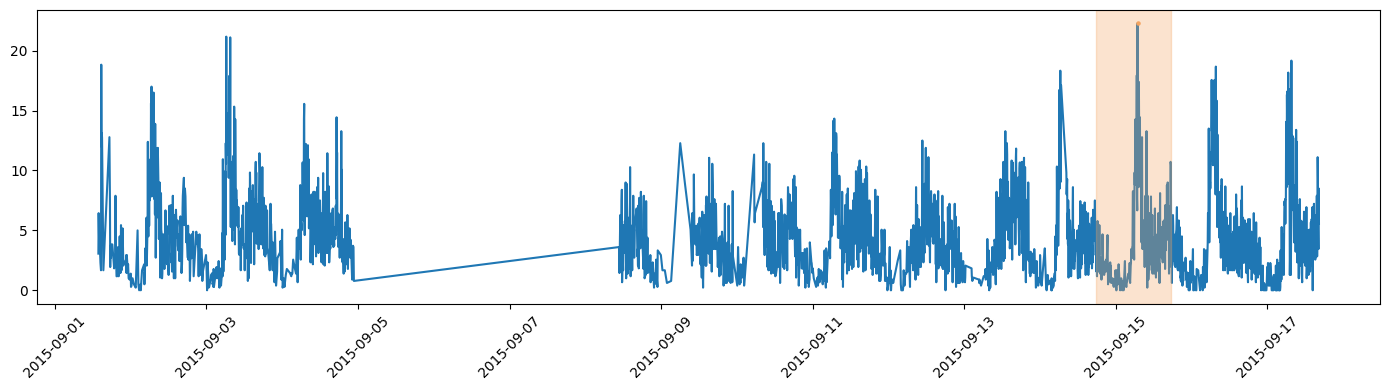

In [2]:
util.plot_series(data, labels, windows, figsize=figsize)

* They have pre-labeled an (easy) anomaly that they wish to detect
* ...But that is _not the most striking aspect_ of this series

## Traffic Data, Again

**There is a _period_, and _straight lines in the plot_**

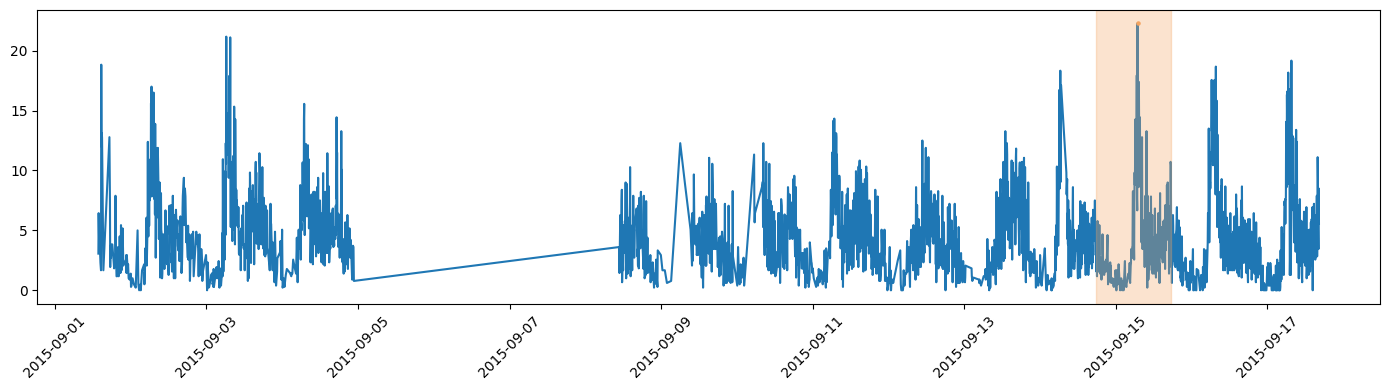

In [3]:
util.plot_series(data, labels, windows, figsize=figsize)

They are _artefacts_, due to _missing values_ in the time series

## Missing Values

**We can make it clearer by explicitly plotting the sampling points**

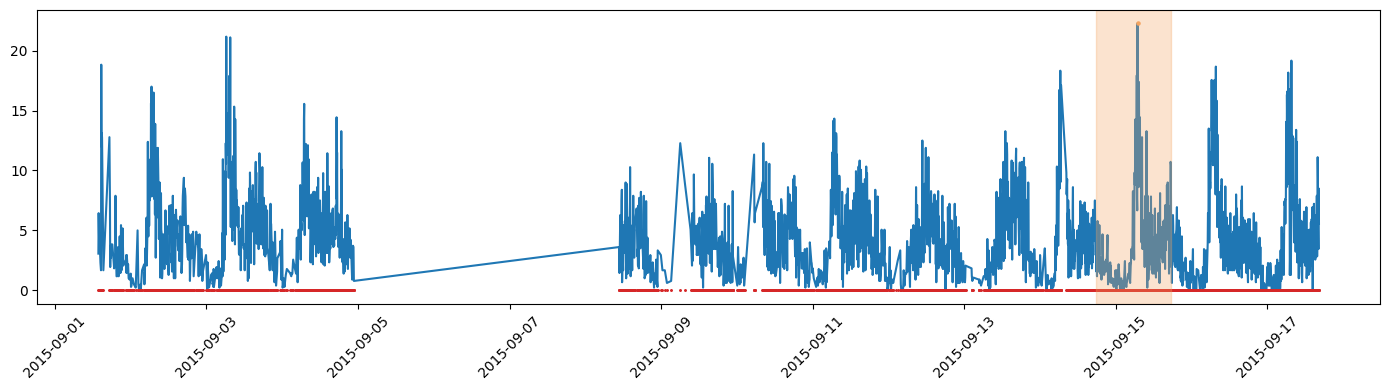

In [4]:
util.plot_series(data, labels, windows, show_sampling_points=True, figsize=figsize)

There is a large gap, plus scattered missing values here and there

## Missing Values in Time Series

**Missing values in real-world time series are _very common_**

They arise for a variety of reasons:

* Malfunctioning sensors
* Network problems
* Lost data
* Sensor maintenance/installation/removal
* ...

**...And can be very annoying to deal with**

* They prevent the application of sliding windows
* They complicate the detection of periods
* ...

# Preparing the Ground

## Preparing the Ground

**Before we can deal with missing values we need to tackle an issue**

I.e. our main series has a _sparse index_

* ...Meaning that index values are non-contiguous
* ...And missing values are represented as gaps

**If we want to fill the missing values...**

* ...We need to decide _where_ the missing values are

> **In other words, we need a _dense_ (temporal) index**

With a dense index:

* Missing values can be represented as NaN (Not a Number)
* ...And can be filled by replacing NaN with a meaningful value

## Choosing a Sampling Frequency

**First, we need to pick a frequency for the new index**

We start by having a look at the typical sampling step in our series:

In [5]:
data.head()

,value
timestamp,
2015-09-01 13:45:00,3.06
2015-09-01 13:50:00,6.44
2015-09-01 13:55:00,5.17
2015-09-01 14:00:00,3.83
2015-09-01 14:05:00,4.50


* The interval between consecutive measurements seems to be 5 minute long
* ...But looking at just a few data points is not enough

## Choosing a Sampling Frequency

**It is much better to compute the distance between consecutive index values**

In [6]:
delta = data.index[1:] - data.index[:-1]
delta[:3]

TimedeltaIndex(['0 days 00:05:00', '0 days 00:05:00', '0 days 00:05:00'], dtype='timedelta64[ns]', name='timestamp', freq=None)

* The difference between two `datetime` objects is a `timedelta` object
* They are all parts of [the `datetime` module](https://docs.python.org/3/library/datetime.html)

**Then we can check the _value counts_**

* This can be done with the `value_counts` method

The methods returns a series:

* The index contains values
* The series data are the corresponding counts

## Choosing a Sampling Frequency

**Let's have a look at our value counts**

In [7]:
vc = pd.Series(delta).value_counts()
vc.iloc[:10]

0 days 00:05:00    1754
0 days 00:10:00     340
0 days 00:15:00     106
0 days 00:20:00      37
0 days 00:04:00      26
0 days 00:25:00      22
0 days 00:06:00      18
0 days 00:30:00       9
0 days 00:35:00       8
0 days 00:11:00       7
Name: timestamp, dtype: int64

**By far the most common value is 5 minutes**

* Some values are not multiples of 5 minutes (e.g. 4, 6, 11 minutes)
* I.e. they are _out of alignment_

## Resampling the Original Dataset

**Therefore, first we need to _realign_ the original index**

This is also called _resampling_ (or _binning_), and can be done in pandas with:

```python
DatetimeIndex.resample(rule=None, ...)
```

* `rule` specifies the length of each individual interval (or "bin")

**Resample is an iterator: we need to choose what to do with each bin**

E.g. compute the mean, stdev, take the first value

In [8]:
ddata = data.resample('5min').mean()
ddata.head()

,value
timestamp,
2015-09-01 13:45:00,3.06
2015-09-01 13:50:00,6.44
2015-09-01 13:55:00,5.17
2015-09-01 14:00:00,3.83
2015-09-01 14:05:00,4.50


## Inspecting the Resampled Dataset

**Now we can inspect this new "dense" series**

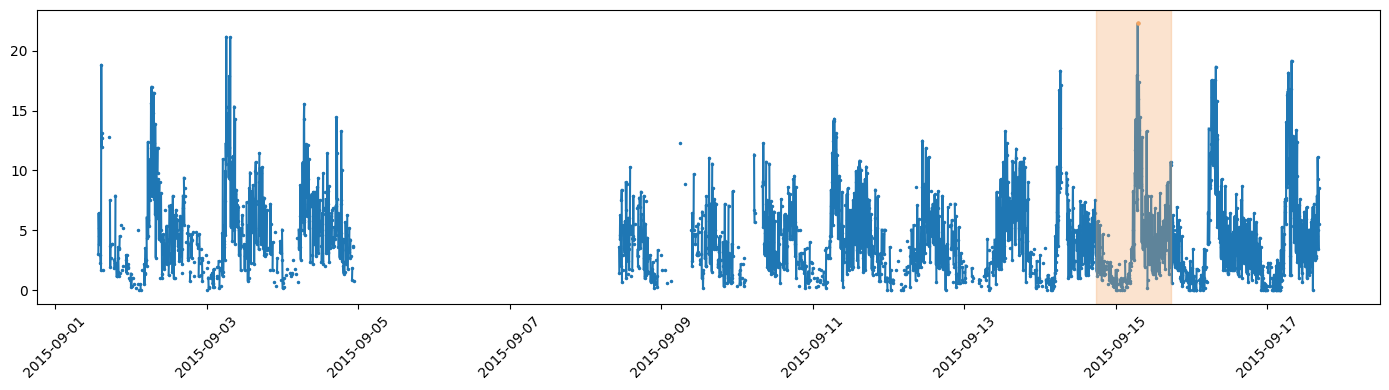

In [9]:
util.plot_series(ddata, labels, windows, show_markers=True, figsize=figsize)

* The artifacts have disappeared!
*...And the true extent of our problem becomes apparent :-)